In [2]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import albumentations as A # image augmentation library for computer vision tasks 
from albumentations.pytorch import ToTensorV2


In [3]:
labels_path = "./rsna_heart_detection.csv"
labels =  pd.read_csv(labels_path)


In [22]:
class CardiacDataset(torch.utils.data.Dataset):

    def __init__(self, path_to_labels_csv, patients, root_path, augs):

        self.labels = pd.read_csv(path_to_labels_csv)
        self.patients = np.load(patients) # array with patient ID names
        self.root_path = Path(root_path)
        self.augment = augs # augmentation pipeline

    def __len__(self):
        """
        Returns the length of the dataset 
        """
        return len(self.patients)

    def __getitem__(self, idx):
        """
        Returns an image paired with the corresponding bounding box around the heart
        """
        # get patient data
        patient = self.patients[idx] # get data according to index
        data = self.labels[self.labels["name"] == patient]

        #extract bounding box coordinates 
        x_min = data["x0"].item() # left edge
        y_min = data["y0"].item() # top edge
        x_max = x_min + data["w"].item() # right edge
        y_max = y_min + data["h"].item() # bottom edge

        #Load image 
        file_path = self.root_path/patient
        img = np.load(f"{file_path}.npy").astype(np.float32) # Converts to float32 for NN processing

        # apply augmentations to both image and bounding box
        if self.augment:
            height , width = img.shape[:2] # image dimensions
            bboxes = [[x_min, y_min, x_max, y_max]]
            # Apply augmentations
            augmented = self.augment(
                image=img,
                bboxes=bboxes,
                class_labels=['heart']  # Albumentations needs class labels for bboxes

            )

            img = augmented['image']

            # Get the augmented bounding box
            if len(augmented['bboxes']) > 0:
                aug_bbox = augmented['bboxes'][0]  # Get first (and only) bbox
                bbox = [aug_bbox[0], aug_bbox[1], aug_bbox[2], aug_bbox[3]]
            else:
                # If bbox was cropped out, use original
                bbox = [x_min, y_min, x_max, y_max]
        else:
            bbox = [x_min, y_min, x_max, y_max]

        # Ensure image is numpy array and correct dtype
        #img = np.array(img, dtype=np.float32)
        
        # Normalize the image to a standard range for better NN training (mean and std dev computed in preprocessing file)
        img = (img - 0.494) / 0.252

        # Convert to tensor and add channel dimension for grayscale
        img = torch.tensor(img,dtype=torch.float32).unsqueeze(0)
        bbox = torch.tensor(bbox, dtype=torch.float32)

        return img, bbox
        
            

In [23]:
# create an augmentation object
seq = A.Compose([
    # Gamma/contrast adjustments
    A.OneOf([
        A.RandomGamma(gamma_limit=(80, 120), p=1.0), # Values are percentages: 80 = 0.8x gamma, 120 = 1.2x gamma
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=1.0),
    ], p=0.8),
    
    # Geometric transformations
    A.Affine(
        scale={'x': (0.8, 1.2), 'y': (0.8, 1.2)}, 
        rotate=(-10, 10),
        translate_px=(-10, 10),
        shear=(-5, 5),  # add slight shearing
        p=0.9
    ),
    
], bbox_params=A.BboxParams( # to track bounding boxes through transformations
    format='pascal_voc',
    label_fields=['class_labels']
))

In [24]:
# test the dataset:
labels_path = "./rsna_heart_detection.csv"
patients_path = "train_subjects.npy"
train_root = "Processed-Heart-Detection/train/"
dataset = CardiacDataset(labels_path, patients_path, train_root, seq)

RuntimeError: Numpy is not available

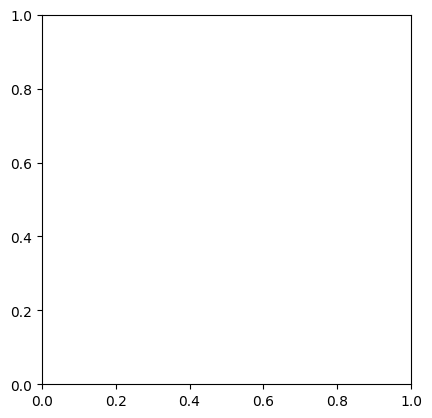

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img, bbox = dataset[0]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor="r", facecolor="none")
axis.add_patch(rect)
axis.set_title("X-RAY with BBOX around heart")
print(bbox)